In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns

from sklearn.model_selection import train_test_split

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
raw_data = pd.read_csv("Pokemon.csv",index_col = 1)
raw_data.drop("#",axis = 1,inplace = True)

In [3]:
raw_data.head()

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
Name,,,,,,,,,,,
Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


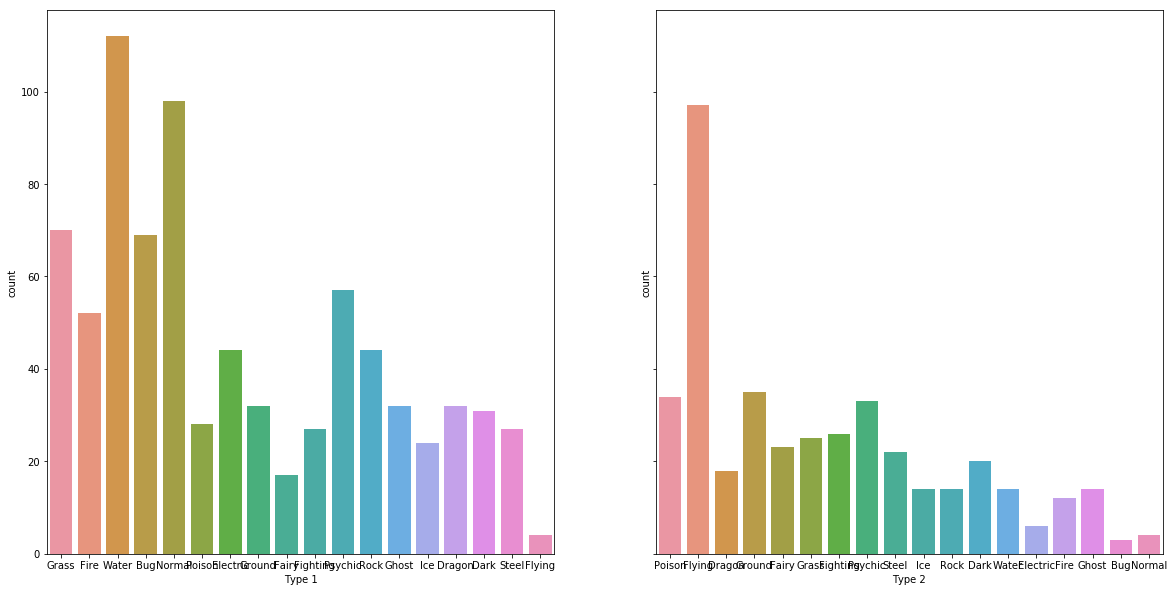

In [4]:
cat_features = ["Type 1","Type 2"]
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
for i in range(len(cat_features)):
    sns.countplot(x=cat_features[i], data = raw_data, ax=axes[i])

In [5]:
types = raw_data["Type 2"].value_counts().index

raw_data["No second type"] = raw_data["Type 2"].apply(lambda x: 1 if pd.isnull(x) else 0)

for pokemon_type in types:
    raw_data[pokemon_type] = raw_data["Type 1"].apply(lambda x: 1 if x == pokemon_type else 0)
    raw_data.loc[raw_data["Type 2"] == pokemon_type,pokemon_type] = raw_data.loc[raw_data["Type 2"] == pokemon_type,
                                                                                 pokemon_type].apply(lambda x: 1)
raw_data["Legendary"] = raw_data["Legendary"].apply(lambda x: 1 if x  else 0)

In [6]:
Legendary = raw_data["Legendary"]
raw_data = raw_data.drop("Legendary",axis = 1)
raw_data["Legendary"] = Legendary

raw_data = raw_data.drop(["Type 1","Type 2"],axis = 1)

In [7]:
from sklearn.utils import shuffle
raw_data = shuffle(raw_data,random_state = 0)

In [8]:


Train_source,Test_source,y_train,y_test = train_test_split(raw_data.drop("Legendary",axis = 1),raw_data["Legendary"],
                                   test_size = 0.33,stratify = raw_data["Legendary"],random_state = 0)

## Структура данных

In [9]:
z = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
       'Generation',"Legendary"]

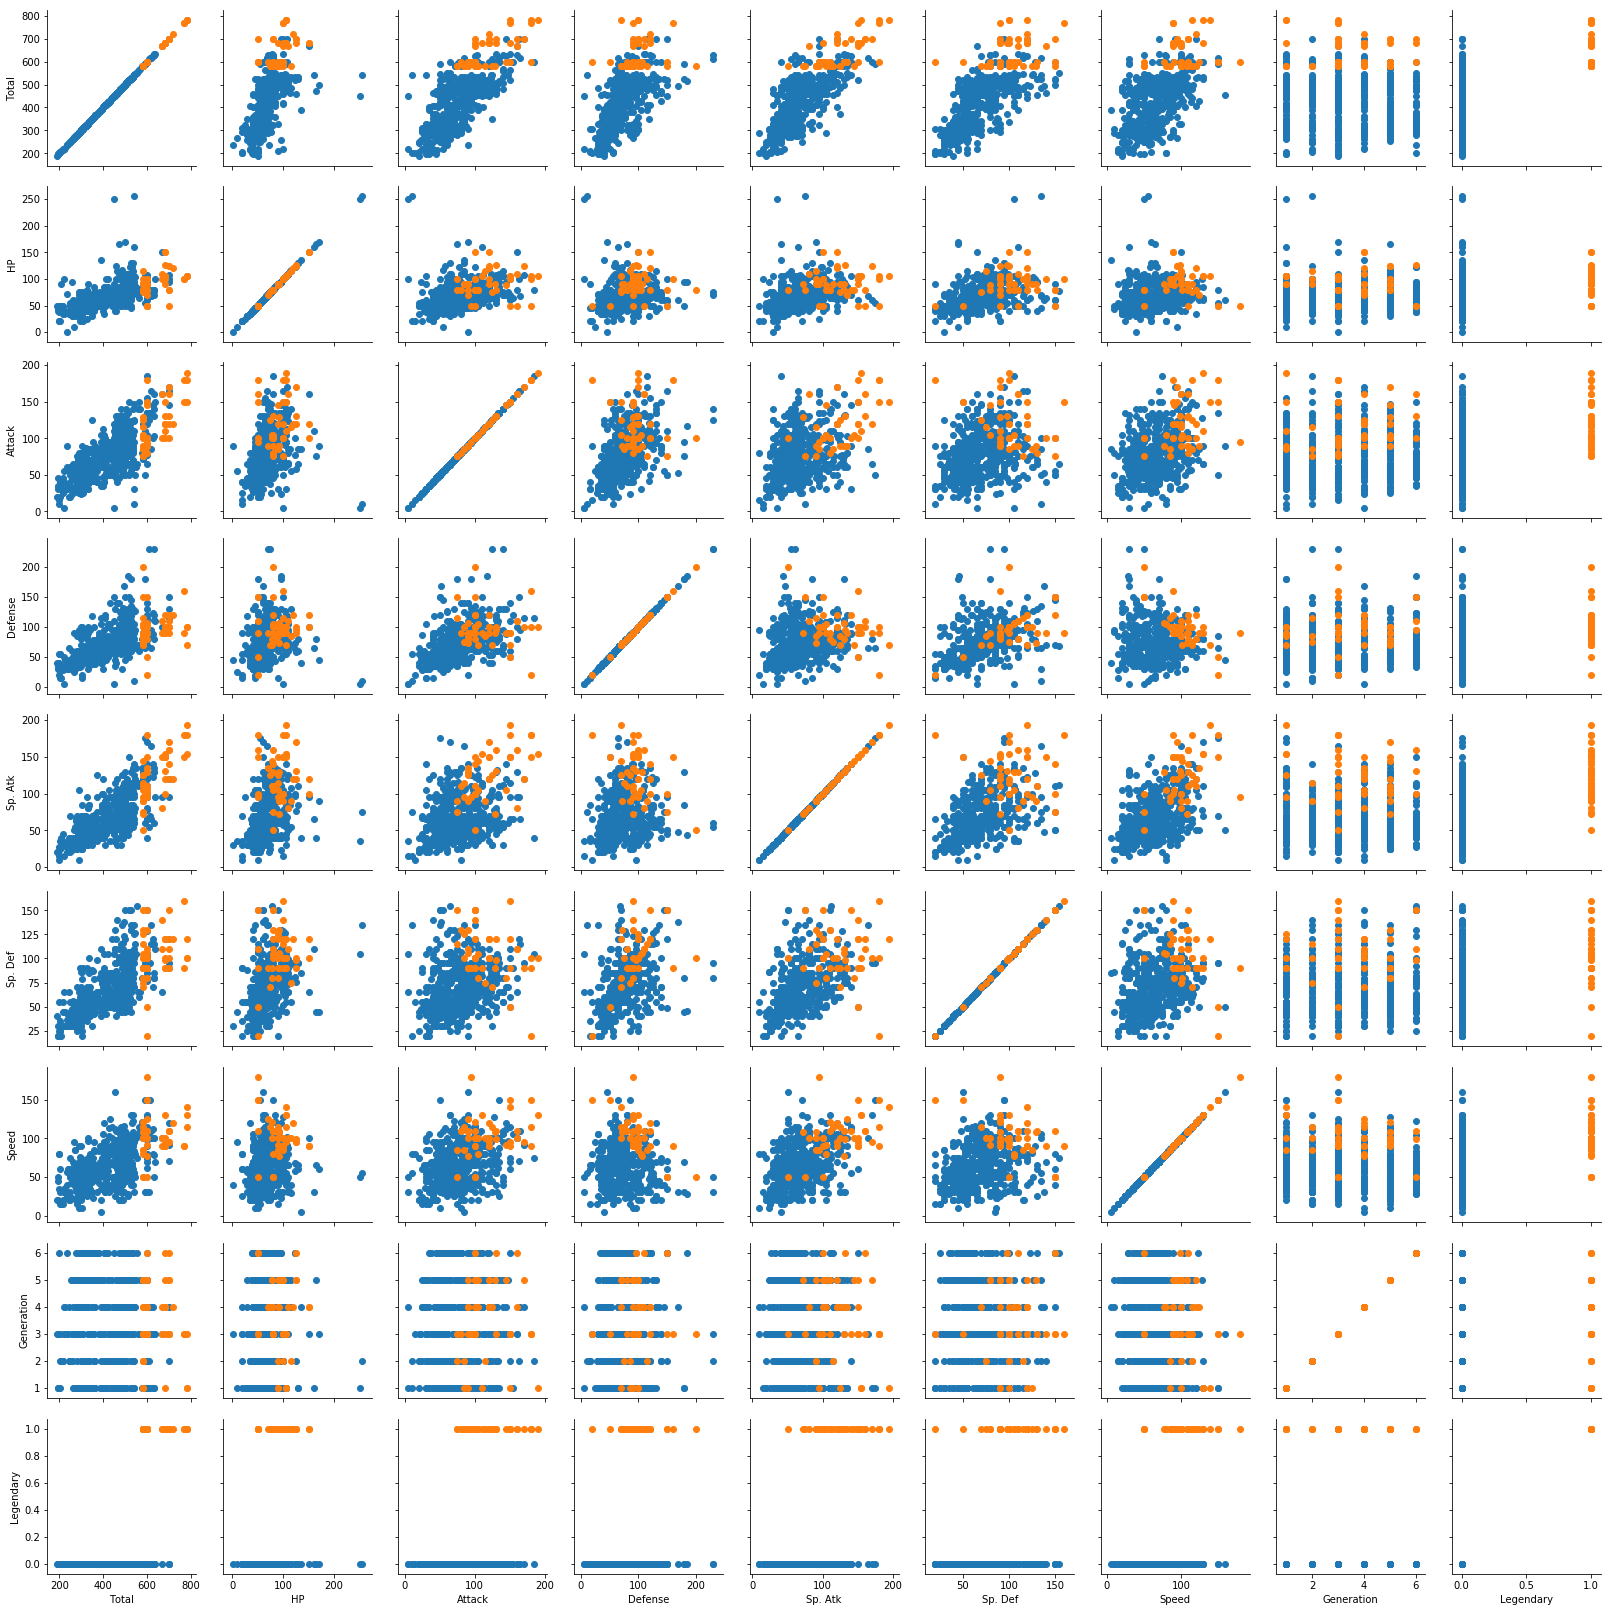

In [10]:
X_visual = pd.DataFrame(Train_source).copy()
X_visual["Legendary"] = y_train
sns.PairGrid(X_visual[z],  hue="Legendary").map(plt.scatter)

* можем наблюдать сильные выбросы у вещественного признака "Hp"
* по форме распределения некоторых признаков можем заметить,что коэффициент корреляции имеет близкие к 1 значения.

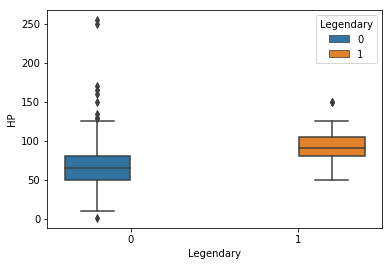

In [11]:
sns.boxplot(x = "Legendary",y = "HP" ,hue = "Legendary",data = X_visual)

In [12]:
from scipy.stats import iqr

In [13]:
false_legend = Train_source.loc[y_train == 0]

false_box_range = ((false_legend.HP.quantile([0.25,0.75])).values[0] - 1.5*iqr(false_legend.HP),
             (false_legend.HP.quantile([0.25,0.75])).values[1] + 1.5*iqr(false_legend.HP))

true_legend = Train_source.loc[y_train == 1]
true_box_range = ((true_legend.HP.quantile([0.25,0.75])).values[0] - 1.5*iqr(true_legend.HP),
             (true_legend.HP.quantile([0.25,0.75])).values[1] + 1.5*iqr(true_legend.HP))

In [14]:
indexes = Train_source.loc[Train_source.HP > false_box_range[1]].index
Train_source.drop(indexes,axis = 0,inplace = True)
y_train.drop(indexes,axis = 0,inplace = True)

Train_source.drop(Train_source.loc[Train_source.HP > false_box_range[1]].index,axis = 0,inplace = True)
y_train.drop(Train_source.loc[Train_source.HP > false_box_range[1]].index,axis = 0,inplace = True)

* избавились в обучающей выборке от нежелательных элементов-выбросов

#### Промасштабируем выборки

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

y_train_before = y_train

In [16]:
scaler = MinMaxScaler()
feature_scale = Train_source.columns[:8].values

In [17]:
train_indexes = Train_source.index
Train_feature = scaler.fit_transform(Train_source.loc[:,feature_scale])
df_feature = pd.DataFrame(Train_feature,index = train_indexes,columns = feature_scale)
nonscale = pd.DataFrame(Train_source.iloc[:,8:],index = train_indexes)

Train_data = pd.concat([df_feature,nonscale],axis = 1)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [18]:
test_indexes = Test_source.index
Test_feature = scaler.fit_transform(Test_source.loc[:,feature_scale])
df_feature_t = pd.DataFrame(Test_feature,index = test_indexes,columns = feature_scale)
nonscale_t = pd.DataFrame(Test_source.iloc[:,8:],index = test_indexes)

Test_data = pd.concat([df_feature_t,nonscale_t],axis = 1)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [19]:
X_train = Train_data
X_test = Test_data

#### классы несбалансированы

In [20]:
print "Количество 1-го класса:",len(X_train[y_train.values == 1])
print "Количество 2-го класса:",len(X_train[y_train.values == 0])

Количество 1-го класса: 41
Количество 2-го класса: 483


In [21]:
np.random.seed(0)
indices_to_add = np.random.randint(0,41,483-41)
indexes = np.arange(0,len(X_train),1)
X_train_to_add = X_train[y_train.values == 1].iloc[indices_to_add]
y_train_to_add = np.linspace(1,1,483 - 41)

X_train = pd.concat([X_train,X_train_to_add])
y_train  = np.hstack((y_train.values,y_train_to_add))

C:\ProgramData\Anaconda2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Качество алгоритма до нормализации: 0.9204545454545454
Качество алгоритма после нормализации: 0.9356060606060606


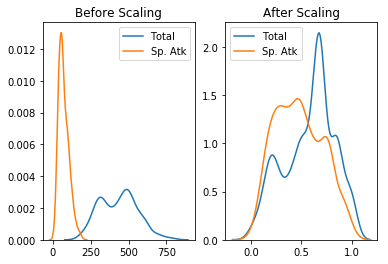

In [22]:
print "Качество алгоритма до нормализации:",KNeighborsClassifier(n_neighbors=2).fit(Train_source, 
                                                                                    y_train_before).score(Test_data, y_test)
     
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title('Before Scaling')
sns.kdeplot(Train_source['Total'], ax=ax1)
sns.kdeplot(Train_source["Sp. Atk"], ax=ax1)


print"Качество алгоритма после нормализации:",KNeighborsClassifier(n_neighbors=2).fit(X_train,
                                                                                      y_train).score(X_test, y_test)

ax2.set_title('After Scaling')
sns.kdeplot(X_train['Total'], ax=ax2)
sns.kdeplot(X_train["Sp. Atk"], ax=ax2)

plt.show()

In [23]:
print "Количество 1-го класса:",len(X_train[y_train == 1])
print "Количество 2-го класса:",len(X_train[y_train == 0])

Количество 1-го класса: 483
Количество 2-го класса: 483


## Подбор алгоритма

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

for clf in [DecisionTreeClassifier(), SGDClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]:
    print(clf.__class__.__name__, clf.fit(X_train, y_train).score(X_test, y_test))

('DecisionTreeClassifier', 0.9090909090909091)
('SGDClassifier', 0.9507575757575758)
('SVC', 0.9015151515151515)
('GaussianNB', 0.35984848484848486)
('KNeighborsClassifier', 0.8939393939393939)


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


* на нашем наборе данных лучше всего себя показывает линейный метод SGDC,что в целом предсказуемо,так как многие переменные имеют большие по модулю(но меньше единицы) коэффициенты корреляции
* убедимся в этом путем сравнения моделей по различным метрикам качества

In [46]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, 
    f1_score, fbeta_score, auc)

In [26]:
def classsifier_quality(a):
    print('Accuracy:', accuracy_score(y_test, a))
    print('Precision:', precision_score(y_test, a))
    print('Recall:', recall_score(y_test, a))
    print('ROC AUC:', roc_auc_score(y_test, a))
    pr, rec, _ = precision_recall_curve(y_test, a)
    print('PRC AUC:', auc(rec, pr))
    print('F1:', f1_score(y_test, a))
    print('F0.5:', fbeta_score(y_test, a, 0.5))
    print('F2:', fbeta_score(y_test, a, 2))

In [27]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
knn_labels = knn_clf.predict(X_test)
knn_predict = knn_clf.predict_proba(X_test)

In [28]:
classsifier_quality(knn_labels)

('Accuracy:', 0.8939393939393939)
('Precision:', 0.37037037037037035)
('Recall:', 0.47619047619047616)
('ROC AUC:', 0.7031158142269254)
('PRC AUC:', 0.4441137566137565)
('F1:', 0.4166666666666667)
('F0.5:', 0.38759689922480617)
('F2:', 0.45045045045045035)


In [29]:
lin_clf = SGDClassifier(loss = "modified_huber")
lin_clf.fit(X_train,y_train)
lin_labels = lin_clf.predict(X_test)
lin_predict = lin_clf.predict_proba(X_test)

classsifier_quality(lin_labels)

('Accuracy:', 0.9659090909090909)
('Precision:', 0.75)
('Recall:', 0.8571428571428571)
('ROC AUC:', 0.9162257495590829)
('PRC AUC:', 0.8092532467532467)
('F1:', 0.7999999999999999)
('F0.5:', 0.7692307692307692)
('F2:', 0.8333333333333333)


In [30]:
tree_clf = DecisionTreeClassifier(random_state=0)
tree_clf.fit(X_train,y_train)
tree_labels = tree_clf.predict(X_test)
tree_predict = tree_clf.predict_proba(X_test)

classsifier_quality(lin_labels)

('Accuracy:', 0.9659090909090909)
('Precision:', 0.75)
('Recall:', 0.8571428571428571)
('ROC AUC:', 0.9162257495590829)
('PRC AUC:', 0.8092532467532467)
('F1:', 0.7999999999999999)
('F0.5:', 0.7692307692307692)
('F2:', 0.8333333333333333)


In [31]:
import sklearn.metrics as metrics

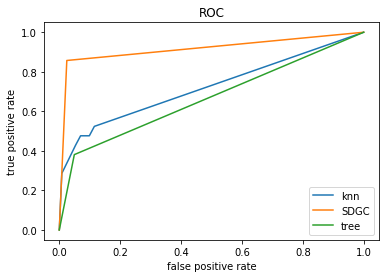

knn:0.720850 SDGC:0.916226 tree:0.665785 


In [32]:
aucs = ""
for  predicted, descr in zip([knn_predict[:,1],lin_predict[:,1],tree_predict[:,1]],
                                    ["knn", "SDGC","tree"]):
    fpr, tpr, thr = metrics.roc_curve(y_test, predicted)
    plt.plot(fpr, tpr,label=descr)
    aucs += descr + ":%3f"%roc_auc_score(y_test, predicted) + " "
plt.title("ROC")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc=4)
plt.show()

print aucs

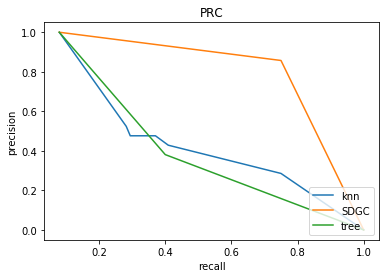

knn:0.451164 SDGC:0.809253 tree:0.415097 


In [33]:
aucs = ""
for  predicted, descr in zip([knn_predict[:,1],lin_predict[:,1],tree_predict[:,1]],
                                    ["knn", "SDGC","tree"]):
    pr, rc, _ = metrics.precision_recall_curve(y_test, predicted)
    plt.plot(pr, rc,label=descr)
    aucs += descr + ":%3f"%auc(rc,pr) + " "
plt.title("PRC")
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc=4)
plt.show()

print aucs

* метод knn не очень подходит к нашим данным,но раз мы взялись за дело,то определимся с метрикой качества
* из условий задачи ясно,что лучше обознаться и принять зверя за редкого,чем упустить заветную добычу.Потому стоит минимизировать FN и максимизировать метрику "recall"

### Knn и recall

* найдем такое количество соседей,которое позволит сделать нашу модель лучше

In [34]:
best_recall_score = -100
best_labels = knn_clf.predict(X_test)
best_k = 0
for n in range(1,41):
    knn_clf_one = KNeighborsClassifier(n_neighbors=n)
    knn_clf_one.fit(X_train,y_train)
    labels = knn_clf_one.predict(X_test)
    predict_proba = knn_clf_one.predict_proba(X_test)
    pr, rc, _ = metrics.precision_recall_curve(y_test, predicted)
    if recall_score(y_test,labels) > best_recall_score:
        best_recall_score = recall_score(y_test,labels)
        best_labels = labels
        best_k = n

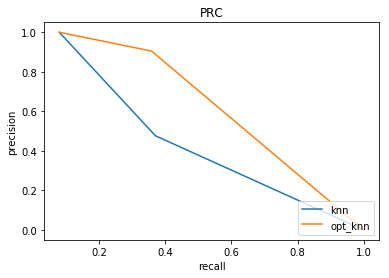

knn:0.444114 opt_knn:0.635414 
Лучшее количество соседей для метрики recall: 27


In [35]:
aucs = ""
for  predicted, descr in zip([knn_labels,best_labels],
                                    ["knn", "opt_knn"]):
    pr, rc, _ = metrics.precision_recall_curve(y_test, predicted)
    plt.plot(pr, rc,label=descr)
    aucs += descr + ":%3f"%auc(rc,pr) + " "
plt.title("PRC")
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc=4)
plt.show()

print aucs
print "Лучшее количество соседей для метрики recall:",best_k

In [36]:
knn_clf = KNeighborsClassifier(n_neighbors = best_k)
knn_clf.fit(X_train,y_train)
knn_labels = knn_clf.predict(X_test)
knn_predict = knn_clf.predict_proba(X_test)

classsifier_quality(knn_labels)

('Accuracy:', 0.8636363636363636)
('Precision:', 0.3584905660377358)
('Recall:', 0.9047619047619048)
('ROC AUC:', 0.8824221046443268)
('PRC AUC:', 0.635414114187699)
('F1:', 0.5135135135135135)
('F0.5:', 0.407725321888412)
('F2:', 0.6934306569343065)


* качество нашей модели для поставленной задачи стало больше

### Сохраним нашу модель

In [37]:
def dropper(X):
    X = X.drop(["Type 1","Type 2"], axis='columns')
    return X

In [38]:
def other_transformations(X):
    types = X["Type 2"].value_counts().index

    X["No second type"] = X["Type 2"].apply(lambda x: 1 if pd.isnull(x) else 0)

    for pokemon_type in types:
        X[pokemon_type] = X["Type 1"].apply(lambda x: 1 if x == pokemon_type else 0)
        X.loc[X["Type 2"] == pokemon_type,pokemon_type] = X.loc[X["Type 2"] == pokemon_type,
                                                                                 pokemon_type].apply(lambda x: 1)
    return X

In [39]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer

pipeline = make_pipeline(
    FunctionTransformer(other_transformations, validate=False),                 # добавили удаление признаков в пайплайн;
                                                                  # параметр validate=False - чтобы функция не пыталась привести все признаки к числам
    FunctionTransformer(dropper, validate=False),   # добавили остальные трансформации признаков
    MinMaxScaler(),                               # нормализацию
    KNeighborsClassifier(n_neighbors=best_k),          # и сам классификатор с наилучшими параметрами
)

pipeline

Pipeline(memory=None,
     steps=[('functiontransformer-1', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function other_transformations at 0x000000001D7BE048>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), ('functiontransformer-2',...i',
           metric_params=None, n_jobs=None, n_neighbors=27, p=2,
           weights='uniform'))])

In [40]:
raw_data = pd.read_csv("Pokemon.csv",index_col = 1)
raw_data.drop("#",axis = 1,inplace = True)

In [41]:
X_raw_tr,X_raw_ts,y_raw_tr,y_raw_ts = train_test_split(raw_data.drop("Legendary",axis = 1),raw_data["Legendary"],
                                   test_size = 0.33,stratify = raw_data["Legendary"],random_state = 0)

In [42]:
pipeline.fit(X_raw_tr, y_raw_tr)
pipeline.score(X_raw_ts, y_raw_ts)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.9242424242424242